# Boundary Layer Final Project

The goal of this project is to determine flow characteristics for turbulent flow from PIV data.

### Project Requirements
* Reproduce the turbulent parts of figure 1.a and 1.b from Adrian. Make the plots for 1.b for y+ = 5, 10, 100, 500
* Find the wall shear stress value by curve fitting a Spaulding profile
* Plot the mean streamwise velocity in wall coordinates
* Find the mixing length as a function of position the boundary layer

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def read_file(file_path, wall=None, index=None):
    '''
    Reads from a tecplot piv data file and returns the y points and average values for u and v
    :param file_path: path to the tecplot piv file
    :param wall: actual y location of the wall in mm, can be unspecified to include all data
    :param index: index of the wall y position in the returned y points
    :return: 
    y_points: list of y distances for the grid
    v_ave: average v value at each y point 
    u_ave: average u value at each y point
    '''
    # Check if a wall offset and index are given
    if wall is None:
        wall = 0.0
    if index is None:
        y_idxs = 324
    else:
        y_idxs = 325 + index
    
    # Initialize data lists
    y_points = []
    v_values = []
    u_values = []
    i = 0
    for j in range(y_idxs):
        v_values.append([])
        u_values.append([])
    
    # Skip beginning profiles if desired
    n = 0    
    skip = 3 + 324*n
    
    # Open the file and read line by line
    with open(file_path, 'r') as file:
        for _ in range(skip):
            next(file)
        for line in file:
            # Split line by space
            parts = line.split()
            
            # Extract the data
            y = float(parts[0])
            v = float(parts[2])
            u = float(parts[3])
            
            # Add to the relevant lists
            if i < y_idxs:
                if -((y-wall)/1000) not in y_points:
                    y_points.append(-((y-wall)/1000))
                if v != 0.0:
                    v_values[i].append(-v)
                if u != 0.0:
                    u_values[i].append(-u)
            
            # Adjust index
            i += 1
            if i==324:
                i = 0
    
    # Average the u and v values
    v_ave = []
    u_ave = []
    for j in range(y_idxs):
        if len(v_values[j])>0:
            v_ave.append(np.mean(v_values[j]))
        else:
            v_ave.append(0.0)
        if len(u_values[j])>0:
            u_ave.append(np.mean(u_values[j]))
        else:
            u_ave.append(0.0)
    return y_points, v_ave, u_ave

In [3]:
# Get averages for u and v for one file
y_cal, v_cal, u_cal = read_file('piv-data/B00001.dat')

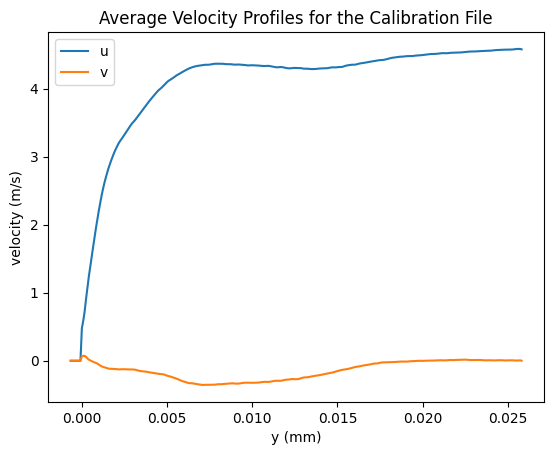

In [4]:
# Plot the averages for u and v across all profiles in the first file
plt.plot(y_cal, u_cal, label="u")
plt.plot(y_cal, v_cal, label="v")
plt.legend()
plt.xlabel("y (mm)")
plt.ylabel("velocity (m/s)")
plt.title("Average Velocity Profiles for the Calibration File")
plt.show()

In [5]:
def find_wall(y_values, v_values):
    '''
    Takes in a v profile and determines the location of the wall using the inflection point
    :param y_values: y distance given in the data file
    :param v_values: v velocity component at y 
    :return: 
    wall_loc: location of the wall using the index found by the min
    '''
    min = np.inf
    count = 0
    min_index = 0
    for i in range(1, len(y_values)):
        ui = v_values[-i]
        if ui != 0.0:
            if ui < min:
                min = ui
                count = 0
                min_index = -i
            else:
                count += 1
        if count >= 3:
            break
    return y_values[min_index], min_index

In [6]:
# Find the wall location based on the average v and y profile for B00001.dat
wall_loc, wall_index = find_wall(y_cal, u_cal)
print("Wall Offset:", wall_loc)
print("u at wall:", u_cal[wall_index])
print("v at wall:", v_cal[wall_index])

Wall Offset: -2.0497e-05
u at wall: 0.4773524615384615
v at wall: 0.06569396923076924


In [7]:
def all_data(num_files, wall_location, wall_idx):
    '''
    Reads all data files and returns u and v averages for each file, and time averages
    :param num_files: number of files to read (valid for up to 10_000)
    :param wall_location: location of the wall in mm based on the original coordinate system
    :param wall_idx: index of the wall y position in the y points list
    :return: 
    y_points: list of y distances for the grid
    v_values: v averages for each file
    u_values: u averages for each file
    v_aves: average v value at each y point across all files
    u_aves: average u value at each y point across all files
    '''
    # Initialize Data Lists
    y_points = []
    v_values = []
    u_values = []
    for i in range(1, num_files+1):
        # Determine the filename (works for num_files < 10_000)
        if i < 10:
            filename = f"piv-data/B0000{i}.dat"
        elif i < 100:
            filename = f"piv-data/B000{i}.dat"
        elif i < 1000:
            filename = f"piv-data/B00{i}.dat"
        else:
            filename = f"piv-data/B0{i}.dat"
        
        # Read the files and add data to lists
        if i == 1:
            y_points, v_file, u_file = read_file(filename, wall=wall_location, index=wall_idx)
        else:
            _, v_file, u_file = read_file(filename, wall=wall_location, index=wall_idx)
        v_values.append(v_file[::-1])
        u_values.append(u_file[::-1])
        
    # Determine the averages
    v_aves = []
    u_aves = []
    for i in range(len(v_values[0])):
        v_sum = 0
        u_sum = 0
        for j in range(len(v_values)):
            v_sum += v_values[j][i]
            u_sum += u_values[j][i]
        v_sum /= len(v_values)
        v_aves.append(v_sum)
        u_sum /= len(u_values)
        u_aves.append(u_sum)
    
    # Return full data and averages
    return y_points[::-1], v_values, u_values, v_aves, u_aves

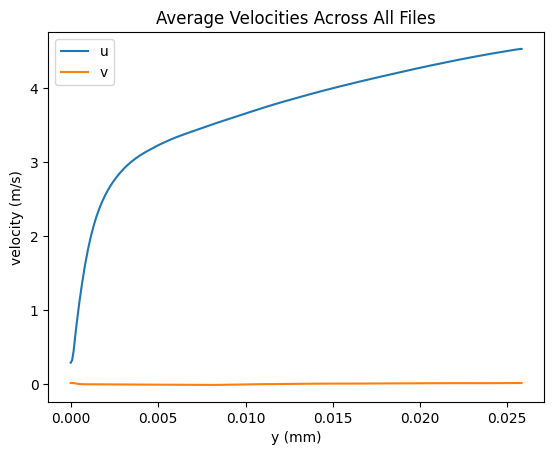

In [8]:
# Get all data and averages with wall data excluded
y, v_all, u_all, v_average, u_average = all_data(1000, wall_loc, wall_index)

# Plot the averages for u and v across all profiles across all files
plt.plot(y, u_average, label="u")
plt.plot(y, v_average, label="v")
plt.legend()
plt.xlabel("y (mm)")
plt.ylabel("velocity (m/s)")
plt.title("Average Velocities Across All Files")
plt.show()

In [9]:
# Define Spalding equation and set variables
kappa = 0.41
B = 5.0
nu = 15.52e-6
rho = 1.184
mu = rho * nu
def spalding_equation(u_bar, y_0, u_tau):
    return nu * (u_bar / (u_tau**2) + np.exp(-kappa * B) / u_tau * (np.exp(kappa * u_bar / u_tau) - 1 - kappa * u_bar / u_tau - kappa**2 * u_bar**2 / (2 * u_tau**2) - kappa**3 * u_bar**3 / (6 * u_tau**3))) + y_0

Optimized parameters:
y_0: 9.999999997976276e-06
u_tau: 0.21413735882498358


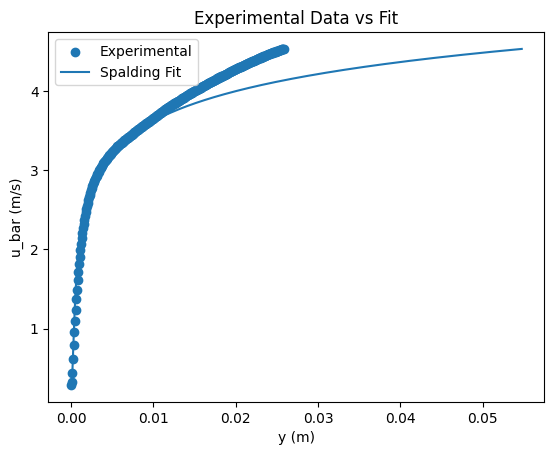

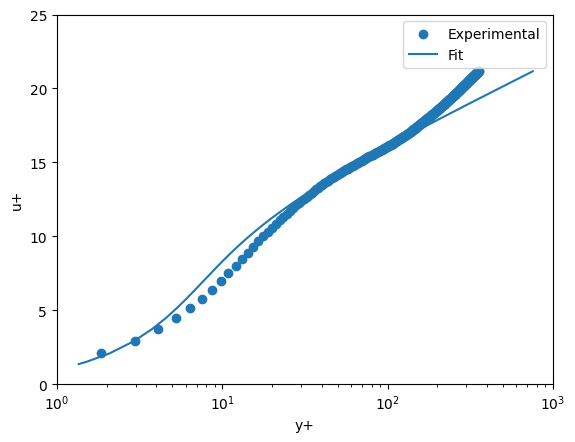

In [10]:
# Use the Spalding profile to get u_tau
initial_guesses = [0, 0.5] #y_0 and u_tau
start = 25
end = 100
popt, pcov = curve_fit(spalding_equation, u_average[start:end], y[start:end], p0=initial_guesses, bounds=([-1e-5, 0], [1e-5, np.inf]), method='trf')
y_0_opt, u_tau_opt = popt

# Print the optimized parameters
print("Optimized parameters:")
print("y_0:", y_0_opt)
print("u_tau:", u_tau_opt)

# Plot the data vs the fit
y_fit = []
for u in u_average:
    y_fit.append(spalding_equation(u, y_0_opt, u_tau_opt))
plt.scatter(y, u_average, label="Experimental")
plt.plot(y_fit, u_average, label="Spalding Fit")
plt.ylabel("u_bar (m/s)")
plt.xlabel("y (m)")
plt.title("Experimental Data vs Fit")
plt.legend()
plt.show()

# Convert to y+ and u+ and plot the experimental data vs the fit
y_plus = []
y_plus_fit = []
u_plus = []
for y_val in y:
    y_plus.append((y_val - y_0_opt) * u_tau_opt / nu)
for y_fit_val in y_fit:
    y_plus_fit.append((y_fit_val - y_0_opt) * u_tau_opt / nu)
for u_val in u_average:
    u_plus.append(u_val / u_tau_opt)
plt.scatter(y_plus, u_plus, label="Experimental")
plt.plot(y_plus_fit, u_plus, label="Fit")
plt.xlabel("y+")
plt.ylabel("u+")
plt.legend()
plt.xscale("log")
plt.ylim([0, 25])
plt.xlim([1, 1000])
plt.show()

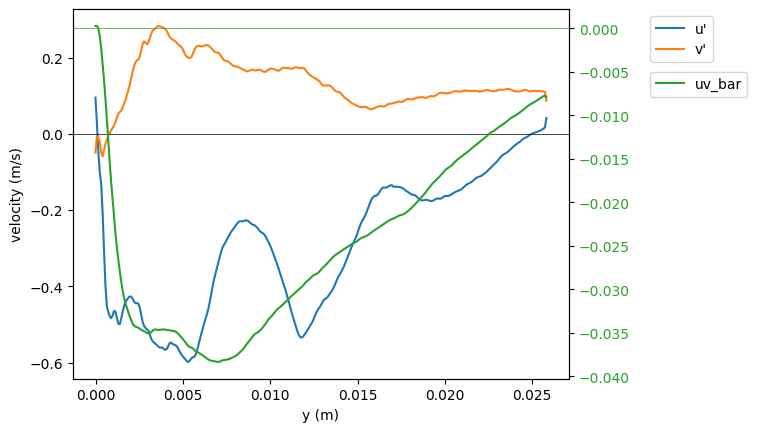

In [40]:
# Calculate u' and v'
u_prime = []
v_prime = []
for i in range(len(u_all)):
    u_prime_file = []
    v_prime_file = []
    for j in range(len(u_average)):
        u_prime_file.append(u_all[i][j] - u_average[j])
        v_prime_file.append(v_all[i][j] - v_average[j])
    u_prime.append(u_prime_file)
    v_prime.append(v_prime_file)

# Calculate uv_bar
uv_prime_ave = []
for i in range(len(u_prime[0])):
    uv_prime_ave.append([])
for i in range(len(u_prime)):
    for j in range(len(u_prime[0])):
        uv_prime_ave[j].append(u_prime[i][j] * v_prime[i][j])
uv_bar = []
for i in range(len(uv_prime_ave)):
    uv_bar.append(np.mean(uv_prime_ave[i]))

# Plot an example from u_prime, v_prime, and uv_bar
examples = [250]
for example in examples:
    fig, ax1 = plt.subplots()
    ax1.plot(y, u_prime[example], label="u\'")
    ax1.plot(y, v_prime[example], label="v\'")
    ax1.axhline(y=0, color='black', linewidth=0.5)
    ax1.set_xlabel("y (m)")
    ax1.set_ylabel("velocity (m/s)")
    ax1.legend()
    
    ax2 = ax1.twinx()
    ax2.plot(y, uv_bar, label="uv_bar", color="tab:green")
    ax2.axhline(y=0, color='tab:green', linewidth=0.5)
    ax2.tick_params(axis="y", labelcolor="tab:green")
    ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))
    plt.show()

In [12]:
# Calculate dU/dy
dudy = []
for i in range(len(u_average)):
    if i == 0:
        du = u_average[i+1] - u_average[i]
        dy = y[i+1] - y[i]
    elif i == len(u_average) - 1:
        du = u_average[i] - u_average[i-1]
        dy = y[i] - y[i-1]
    else:
        du = u_average[i+1] - u_average[i-1]
        dy = y[i+1] - y[i-1]
    dudy.append(du / dy)

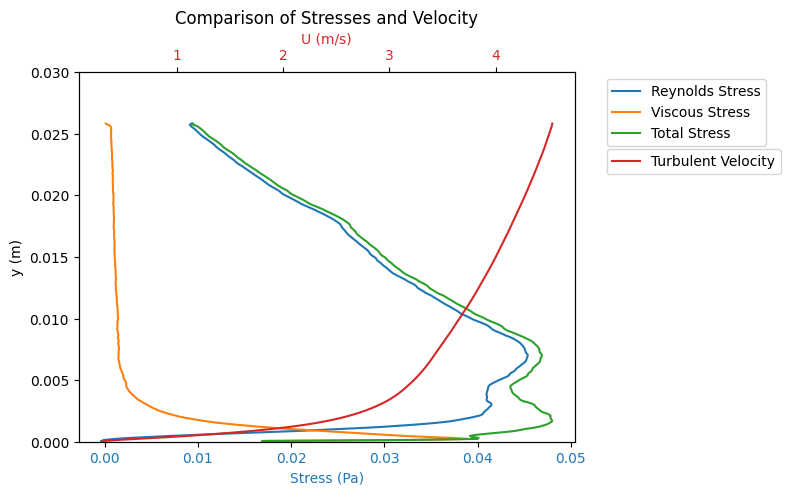

In [13]:
# Create Fig. 1a

# Calculate Reynolds Shear Stress
reynolds_stress = []
for uv in uv_bar:
    reynolds_stress.append(-uv * rho)

# Calculate Viscous Stress
viscous_stress = []
for ddy in dudy:
    viscous_stress.append(mu * ddy)

# Calculate Total Stress
total_stress = []
for i in range(len(reynolds_stress)):
    total_stress.append(reynolds_stress[i] + viscous_stress[i])

# Plot the Stresses
stress_start = 1
fig, ax1 = plt.subplots()
ax1.plot(reynolds_stress[stress_start:], y[stress_start:], label="Reynolds Stress")
ax1.plot(viscous_stress[stress_start:], y[stress_start:], label="Viscous Stress")
ax1.plot(total_stress[stress_start:], y[stress_start:], label="Total Stress")
ax1.set_xlabel("Stress (Pa)", color='tab:blue')
ax1.set_ylabel("y (m)")
ax1.set_ylim([0.0, 0.03])
ax1.tick_params(axis='x', labelcolor='tab:blue')

ax2 = ax1.twiny()
ax2.plot(u_average, y, label="Turbulent Velocity", color='tab:red')
ax2.set_xlabel("U (m/s)", color='tab:red')
ax2.tick_params(axis='x', labelcolor='tab:red')

plt.title("Comparison of Stresses and Velocity")
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.81))
plt.show()

In [19]:
def y_plus_to_y(y_p, u_t, nu_fluid, y_offset):
    return y_p * nu_fluid / u_t + y_offset

def u_tau_to_tau_w(u_tau, rho_fluid):
    return u_tau**2 * rho_fluid

def pdf_plot(u_prime, v_prime, index, y_plus_val):
    '''
    
    :param u_prime: 
    :param v_prime: 
    :param index: 
    :param y_plus_val: 
    :return: 
    '''
    # Get the u and v coordinates
    u_prime_coords = []
    v_prime_coords = []
    tl = 0
    tr = 0
    br = 0
    bl = 0
    for i in range(len(u_prime)):
        u_val = u_prime[i][index]
        v_val = v_prime[i][index]
        u_prime_coords.append(u_val)
        v_prime_coords.append(v_val)
        if u_val <= 0 < v_val:
            tl += 1
        elif u_val > 0 and v_val > 0:
            tr += 1
        elif u_val >= 0 >= v_val:
            br += 1
        else:
            bl += 1
            
    # Get axis limits
    v_max = max(v_prime_coords)
    u_max = max(u_prime_coords)
    ax_max = max(v_max, u_max)
    
    # Plot the data
    plt.scatter(u_prime_coords, v_prime_coords, s=3)
    plt.xlabel("u")
    plt.ylabel("v")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    #plt.xlim([-ax_max, ax_max])
    #plt.ylim([-ax_max/4, ax_max/4])
    plt.title(f"u-v Probability Density Function at y+={y_plus_val}")
    plt.show()
    
    # Return the counts per quadrant
    return [tl, tr, br, bl]

1000 1000
y+  : y
5   : 0.00037238
10  : 0.00073477
100 : 0.0072577
y_max: 0.025824855503


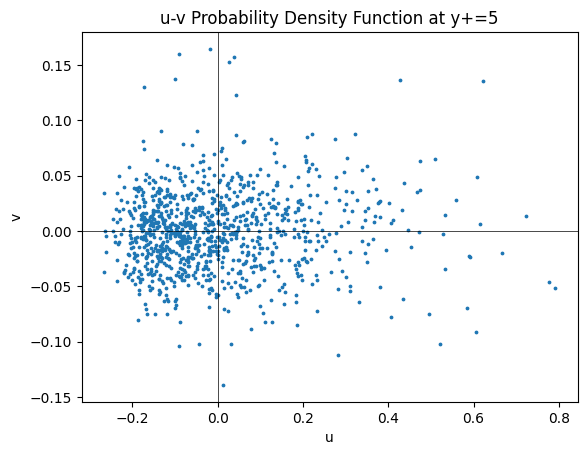

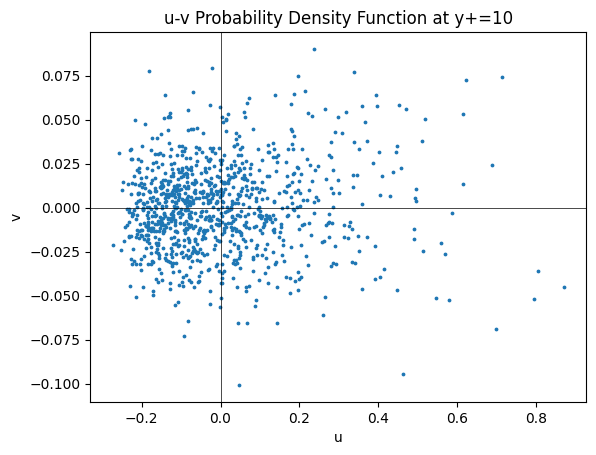

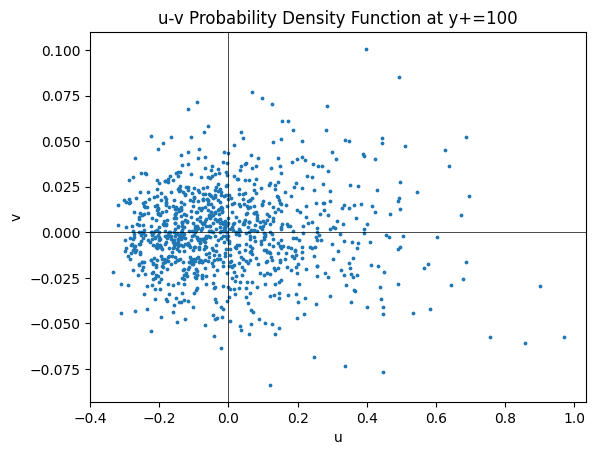

In [26]:
# Create Fig. 1b
y_plus_list = [5, 10, 100]
pdf_y = []
for yplus in y_plus_list:
    pdf_y.append(y_plus_to_y(yplus, u_tau_opt, nu, y_0_opt))
print("y+  : y")
print(f"5   : {pdf_y[0]:0.5}")
print(f"10  : {pdf_y[1]:0.5}")
print(f"100 : {pdf_y[2]:0.5}")
print("y_max:", y[-1])

# Find the indexes to plot
j = 0
pdf_index = []
for i in range(len(y)):
    if j >= len(pdf_y):
        break
    elif y[i] > pdf_y[j]:
        pdf_index.append(i)
        j += 1

# Plot at the y+ values
count = []
for plot_num in range(len(pdf_index)):
    count.append(pdf_plot(u_prime, v_prime, plot_num, y_plus_list[plot_num]))

In [25]:
for i in range(len(pdf_index)):
    counts = count[i]
    total = sum(counts)
    print(f"y+={y_plus_list[i]}")
    print(f"Top Left: {counts[0]} ({100 * counts[0]/total}%)")
    print(f"Top Right: {counts[1]} ({100 * counts[1]/total}%)")
    print(f"Bottom Right: {counts[2]} ({100 * counts[2]/total}%)")
    print(f"Bottom Left: {counts[3]} ({100 * counts[3]/total}%)\n")

y+=5
Top Left: 276 (27.6%)
Top Right: 220 (22.0%)
Bottom Right: 191 (19.1%)
Bottom Left: 313 (31.3%)

y+=10
Top Left: 276 (27.6%)
Top Right: 216 (21.6%)
Bottom Right: 200 (20.0%)
Bottom Left: 308 (30.8%)

y+=100
Top Left: 291 (29.1%)
Top Right: 202 (20.2%)
Bottom Right: 210 (21.0%)
Bottom Left: 297 (29.7%)



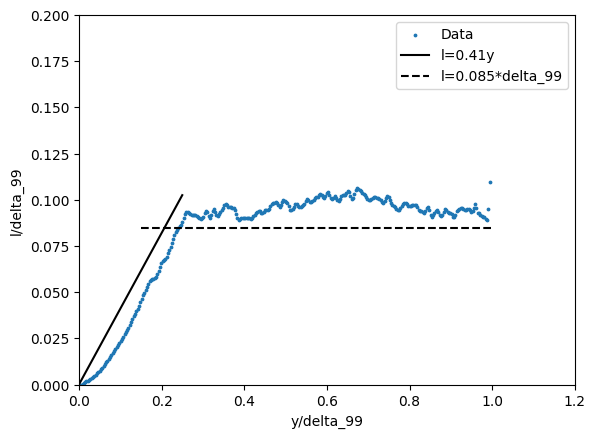

In [16]:
# Determine delta_99
u_inf = max(u_average)
delta_99 = 0
for i in range(len(u_average)):
    if u_average[i] > u_inf * 0.99:
        delta_99 = y[i]

# Find l
mixing_length = []
for i in range(len(uv_bar)):
    if uv_bar[i] < 0 and dudy[i] != 0:
        mixing_length.append(np.sqrt(-uv_bar[i] / (dudy[i]**2)))
    else:
        mixing_length.append(0)

# Get scaled values
y99 = []
l99 = []
for i in range(len(y)):
    y99.append(y[i] / delta_99)
    l99.append(mixing_length[i] / delta_99)

flat = np.linspace(0.15, 1.0, 50)
flat_y = []
for i in flat:
    flat_y.append(0.085)

enter = np.linspace(0.0, 0.25, 50)
enter_y = []
for ydiv99 in enter:
    enter_y.append(ydiv99*0.41)

# Plot the figure
ml_end = -2
plt.scatter(y99[:ml_end], l99[:ml_end], s=3, label="Data")
plt.plot(enter, enter_y, color='black', label="l=0.41y")
plt.plot(flat, flat_y, color='black', linestyle="dashed", label="l=0.085*delta_99")
plt.xlabel("y/delta_99")
plt.ylabel("l/delta_99")
plt.legend()
plt.xlim([0, 1.2])
plt.ylim([0, 0.2])
plt.show()